## Loading Data

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras import layers
from tensorflow import data as tf_data
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_augmentation=keras.Sequential([
    layers.RandomContrast(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2)
])

In [3]:
# tfds.disable_progress_bar()
train_60,val_20,test_20=tfds.load("oxford_iiit_pet",split=["train","test[:50%]","test[50%:]"],as_supervised=True)

resizing=layers.Resizing(224,224)
train_60=train_60.map(lambda x,y:(resizing(x),y),num_parallel_calls=tf_data.AUTOTUNE)
val_20=val_20.map(lambda x,y:(resizing(x),y),num_parallel_calls=tf_data.AUTOTUNE)
test_20=test_20.map(lambda x,y:(resizing(x),y),num_parallel_calls=tf_data.AUTOTUNE)

train_60_1=train_60.map(lambda x,y:(data_augmentation(x,training=True),y),num_parallel_calls=tf_data.AUTOTUNE)

train_60=train_60.concatenate(train_60_1).shuffle(1000)

batch_size = 64

train_60 = train_60.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
val_20 = val_20.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_20 = test_20.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

In [2]:
train,test=tfds.load("oxford_iiit_pet",split=["train","test"],as_supervised=True,)

resizing=layers.Resizing(224,224)
train=train.map(lambda x,y:(resizing(x),y))
test=test.map(lambda x,y:(resizing(x),y))

batch_size = 64

train = train.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test = test.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

In [5]:
F10_train=tfds.load("oxford_iiit_pet",split=[f"train[:{r}%]+train[{r+10}%:]" for r in range(0,100,10)],as_supervised=True)
F10_val=tfds.load("oxford_iiit_pet",split=[f"train[{r}%:{r+10}%]" for r in range(0,100,10)],as_supervised=True)

## Model

In [4]:
base_model=keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(224,224,3),pooling="avg")

In [5]:
base_model.trainable=False

In [27]:
inputs=keras.Input(shape=(224,224,3))   
preprocessing=tf.keras.applications.resnet.preprocess_input(inputs)
x=base_model(preprocessing, training=False)
x=layers.Dense(256,activation="swish")(x)
x=layers.Dropout(0.5)(x)    
outputs=layers.Dense(37)(x)

model=keras.Model(inputs,outputs)

loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizers=keras.optimizers.Adam(learning_rate=0.0002,decay=0.0005)

model.compile(optimizer=optimizers,loss=loss_fn,metrics=[keras.metrics.SparseTopKCategoricalAccuracy( k=1, name="accuracy")])

In [7]:
model.summary(show_trainable=True) 

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         Y          
 licingOpLambda)                                                            
                                                                            
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         Y          
                                                                            
 resnet50 (Functional)       (None, 2048)              23587712  N          
                                                                            
 dense (Dense)               (None, 256)               524544    Y          
                                                             

In [ ]:
callback=EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
history=model.fit(train_60,epochs=50,validation_data=val_20)

In [14]:
model.evaluate(test_20)   

29/29 [==============================] - 5s 183ms/step - loss: 0.3379 - accuracy: 0.8986


[0.3378755450248718, 0.898637592792511]

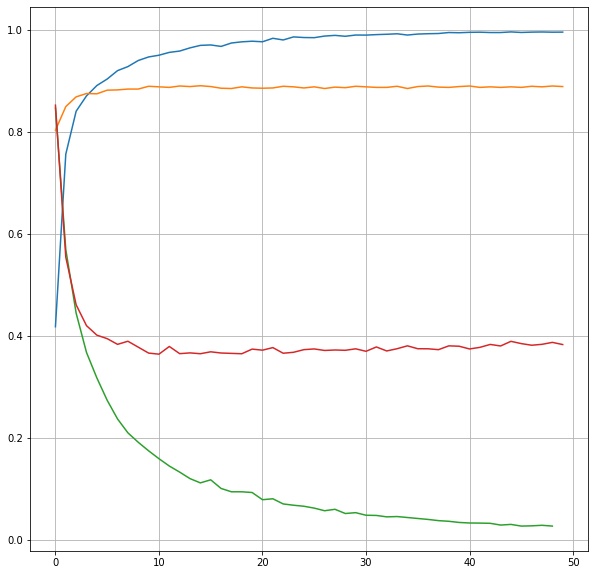

In [22]:
#plot the graph
plt.figure(figsize=(10,10))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"][1:])
plt.plot(history.history["val_loss"])
plt.grid(True)
plt.show()

In [24]:
base_model.trainable=True
loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizers=keras.optimizers.Adam(learning_rate=0.000001)

model.compile(optimizer=optimizers,loss=loss_fn,metrics=[keras.metrics.SparseTopKCategoricalAccuracy( k=1, name="accuracy")])

In [26]:
model.fit(train_60,epochs=50,validation_data=val_20,callbacks=[callback])

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/resnet50/conv3_block3_3_bn/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 362, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 265, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 540, in execute_request
      self.do_execute(
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2877, in run_cell
      result = self._run_cell(
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2923, in _run_cell
      return runner(coro)
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3146, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\dinuk\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-25-39c1608bf922>", line 1, in <module>
      model.fit(train_60,epochs=50,validation_data=val_20,callbacks=[callback])
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\dinuk\anaconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 649, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_2/resnet50/conv3_block3_3_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[64,512,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/resnet50/conv3_block3_3_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_104165]